In [41]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

As described in the Data Overview, there are 10 folders labelled 00 to 09, each containing images from a given subject. In each folder there are subfolders for each gesture. We'll build a dictionary `lookup` storing the names of the gestures we need to identify, and giving each gesture a numerical identifier. We'll also build a dictionary `reverselookup` that tells us what gesture is associated to a given identifier.

In [43]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('./archive/leapGestRecog/leapGestRecog/00/'):
    if not j.startswith('.'): # To ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'05_thumb': 0,
 '08_palm_moved': 1,
 '02_l': 2,
 '01_palm': 3,
 '07_ok': 4,
 '10_down': 5,
 '06_index': 6,
 '09_c': 7,
 '03_fist': 8,
 '04_fist_moved': 9}

Next we read in the images, storing them in `x_data`. We store the numerical classifier for each image in `y_data`. Since the images are quite large and are coming from an infra-red sensor, there's nothing really lost in converting them to greyscale and resizing to speed up the computations.

In [45]:
x_data = []
y_data = []
datacount = 0
for i in range(0, 10):
    for j in os.listdir('./archive/leapGestRecog/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'): 
            count = 0 
            for k in os.listdir('./archive/leapGestRecog/leapGestRecog/0' + 
                                str(i) + '/' + j + '/'):

                img = Image.open('./archive/leapGestRecog/leapGestRecog/0' + 
                                 str(i) + '/' + j + '/' + k).convert('L')

                img = img.resize((320, 120))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size

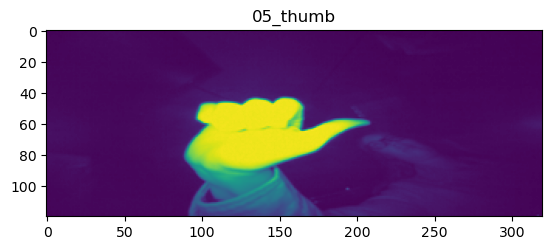

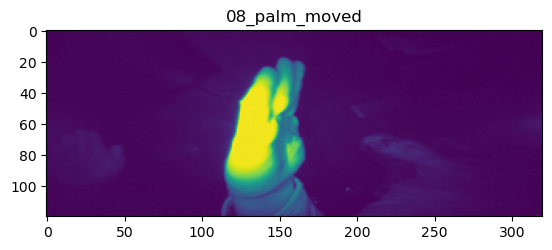

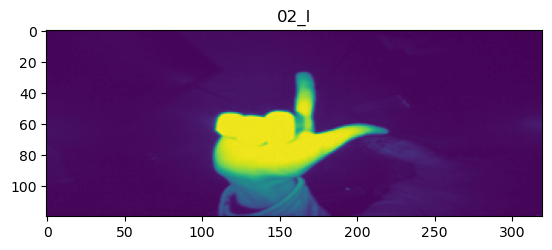

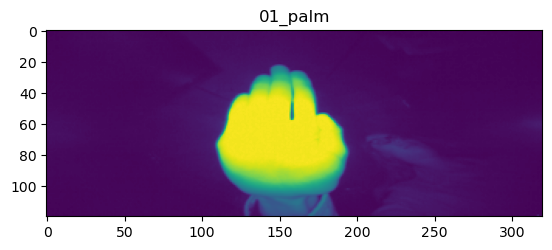

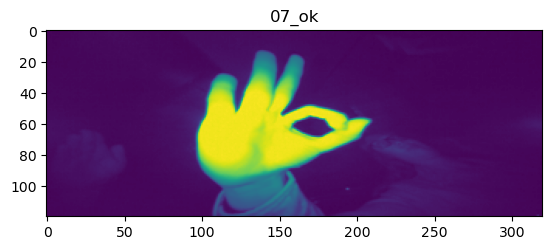

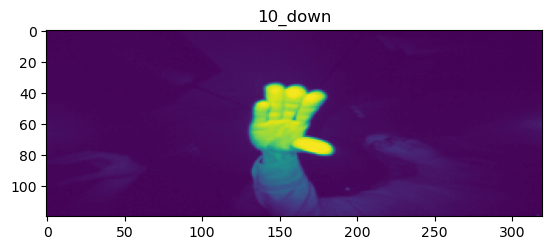

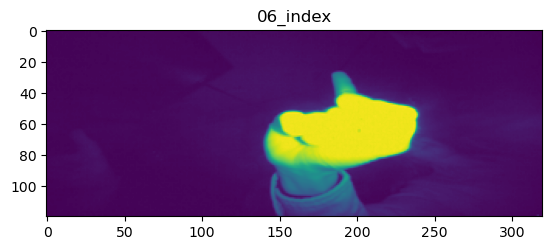

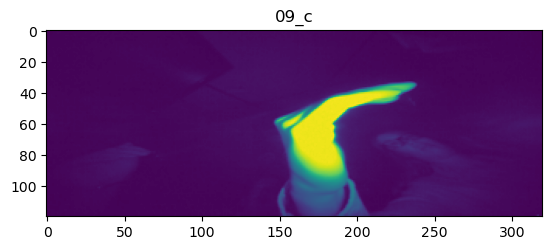

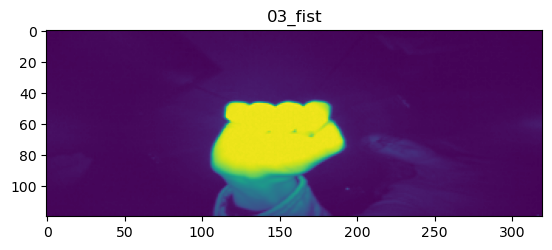

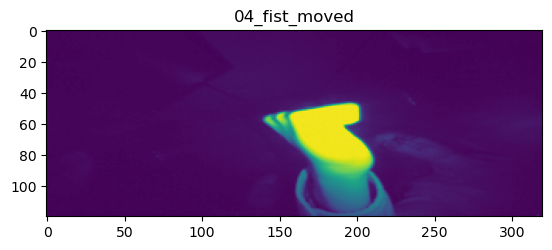

In [46]:
from random import randint
for i in range(0, 10):
    plt.imshow(x_data[i*200 , :, :])
    plt.title(reverselookup[y_data[i*200 ,0]])
    plt.show()


In [47]:
import keras
from keras.utils import to_categorical
y_data = to_categorical(y_data)

In [48]:
x_data = x_data.reshape((datacount, 120, 320, 1))
x_data /= 255

In [49]:
from sklearn.model_selection import train_test_split
x_train,x_further,y_train,y_further = train_test_split(x_data,y_data,test_size = 0.2)
x_validate,x_test,y_validate,y_test = train_test_split(x_further,y_further,test_size = 0.5)

In [50]:
from keras import layers
from keras import models

In [52]:
model=models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(120, 320,1))) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [54]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1, validation_data=(x_validate, y_validate))

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 95s 377ms/step - accuracy: 0.7160 - loss: 0.8317 - val_accuracy: 0.9980 - val_loss: 0.0068
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 323ms/step - accuracy: 0.9963 - loss: 0.0148 - val_accuracy: 0.9995 - val_loss: 0.0014
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 315ms/step - accuracy: 0.9982 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 1.0921e-04
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 317ms/step - accuracy: 0.9997 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 4.6615e-05
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 321ms/step - accuracy: 1.0000 - loss: 3.0732e-05 - val_accuracy: 1.0000 - val_loss: 2.1808e-05
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 316ms/step - accuracy: 1.0000 - loss: 2.8070e-06 - val_accuracy: 1.0000 - val_loss: 1.3290e-05
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 320ms/step - accuracy: 1.0000 - loss: 1.6033e-06 - val_accuracy: 1.0000 - val_loss: 1.0117e-05
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 318ms/s

We can see we're getting perfect accuracy on the validation set after just one or two epochs, so we're pretty much done. Let's quickly confirm that this is carrying through to the test set:

In [56]:
[loss, acc] = model.evaluate(x_test,y_test,verbose=1)
print("Accuracy:" + str(acc))

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 1.0000 - loss: 6.4983e-05
Accuracy:1.0
